<img src="img/statworx.png" style="height:35px; float:right">

# Cluster - Explainability & Causality
## Uplift Modeling


Fran Peric\
15.07.2022

---

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import causalml
from causalml.inference.tree import UpliftRandomForestClassifier, UpliftTreeClassifier
from causalml.metrics import plot_gain

### Data - Criteo AI Lab

In [2]:
df = pd.read_csv("data/uplift-v2.1.csv")
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


### Data Exploration

In [13]:
df.shape

(13979592, 16)

In [14]:
df.treatment.value_counts()

1    11882655
0     2096937
Name: treatment, dtype: int64

In [15]:
df.treatment.value_counts(normalize = True)

1    0.85
0    0.15
Name: treatment, dtype: float64

In [7]:
df.pivot_table(
    values="conversion",
    index="treatment",
    aggfunc=[np.mean, np.size],
    margins=True
)

,mean,size
,conversion,conversion
treatment,,
0,0.001938,2096937
1,0.003089,11882655
All,0.002917,13979592


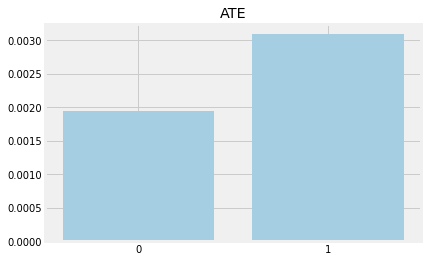

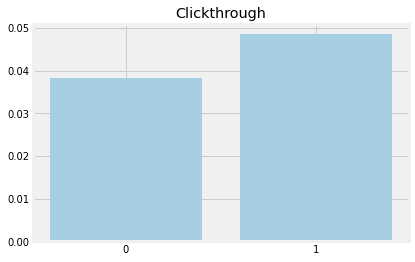

In [6]:
ate = df.groupby("treatment").conversion.agg(avg_conv=("mean"), sum_conv=("sum"))
plt.bar(x=ate.index, height=ate.avg_conv, tick_label=ate.index)
plt.title("ATE")
plt.show()

click = df.groupby("treatment").visit.agg(avg_click=("mean"))
plt.bar(x=click.index, height=click.avg_click, tick_label=click.index)
plt.title("Clickthrough")
plt.show()

### Modeling

In [8]:
model_df = df.copy()
model_df["is_treated"] = model_df.treatment
model_df.treatment = np.where(model_df.treatment==1, "treatment", "control")
model_df.drop(columns=["visit", "exposure"], inplace=True)

df_train, df_test = train_test_split(model_df, test_size=0.2, random_state=42)

In [10]:
uplift_model = UpliftRandomForestClassifier(control_name='control')

uplift_model.fit(df_train.iloc[:, :12].values,
                 treatment=df_train['treatment'].values,
                 y=df_train['conversion'].values)

df_res = uplift_model.predict(df_test.iloc[:, :12].values, full_output=True)
print(df_res.shape)

(2795919, 5)


,treatment
0,0.001117
1,0.000569
2,0.000470
3,0.000438
4,0.000145


In [11]:
df_res.head()

,control,treatment,recommended_treatment,delta_treatment,max_delta
0,0.001152,0.002269,1,0.001117,0.001117
1,0.000725,0.001294,1,0.000569,0.000569
2,0.001319,0.001788,1,0.000470,0.000470
3,0.001280,0.001718,1,0.000438,0.000438
4,0.000800,0.000945,1,0.000145,0.000145


In [ ]:
y_pred = uplift_model.predict(df_test.iloc[:, :12].values)

y_pred.shape

result = pd.DataFrame(y_pred,
                      columns=uplift_model.classes_[1:])
result.head()

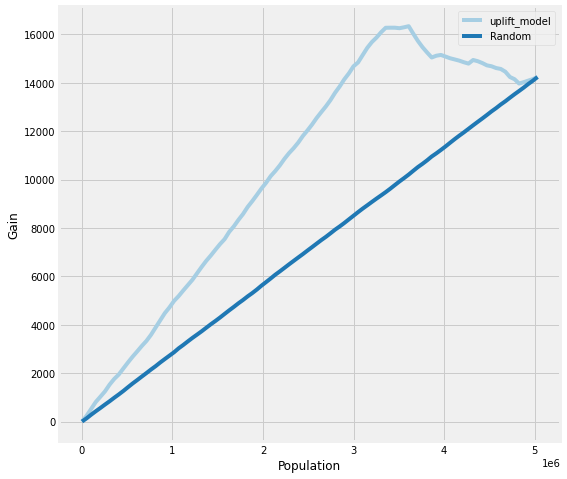

In [12]:
pred_overview = pd.DataFrame({
    "conversion": df_test.conversion,
    "is_treated": df_test.is_treated,
    "uplift_model": df_res.delta_treatment
})

plot_gain(pred_overview, outcome_col="conversion", treatment_col="is_treated")
plt.show()

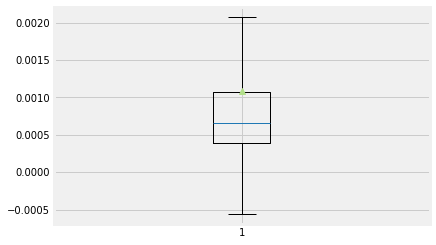

In [28]:
uplift_dist = plt.boxplot(y_pred, showfliers=False, showmeans=True)